In [19]:
import pandas as pd
import mlflow

In [117]:
# Get mlflow runs
from mlflow import MlflowClient

mlflow_client = MlflowClient(tracking_uri="file:///workspace/plm-train/mlruns/")
cope_exp = mlflow_client.get_experiment_by_name("CoPE")
cope_runs = mlflow_client.search_runs(cope_exp.experiment_id)

# Get cope_run ids
run_ids = [cope_run.info.run_id for cope_run in cope_runs]





In [118]:
def metric_to_df(history):
    # Convert metric dictionary to dataframe
    metric_df = pd.DataFrame(history)



# Get metrics
metric_df = []
for run_id in run_ids:
    metrics = ["train_loss", "mean_val_loss"]
    for metric in metrics:
        tmp_list = mlflow_client.get_metric_history(run_id, metric)
        run_tags = mlflow_client.get_run(run_id).data.tags
        # Create a dataframe
        history = [dict(metric=m.key, value=m.value, timestamp=m.timestamp, step=m.step) for m in tmp_list]
        history = pd.DataFrame(history).sort_values("step")
        history.timestamp = pd.to_datetime(history.timestamp, unit="ms")
        history["run_id"] = run_id
        history["pos_encoding_type"] = run_tags["pos_emb_type"]
        metric_df.append(history)

metric_df = pd.concat(metric_df)
metric_df["metric"] = metric_df["metric"].replace("mean_val_loss", "val_loss")


/tmp/ipykernel_34462/3078895979.py:4: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


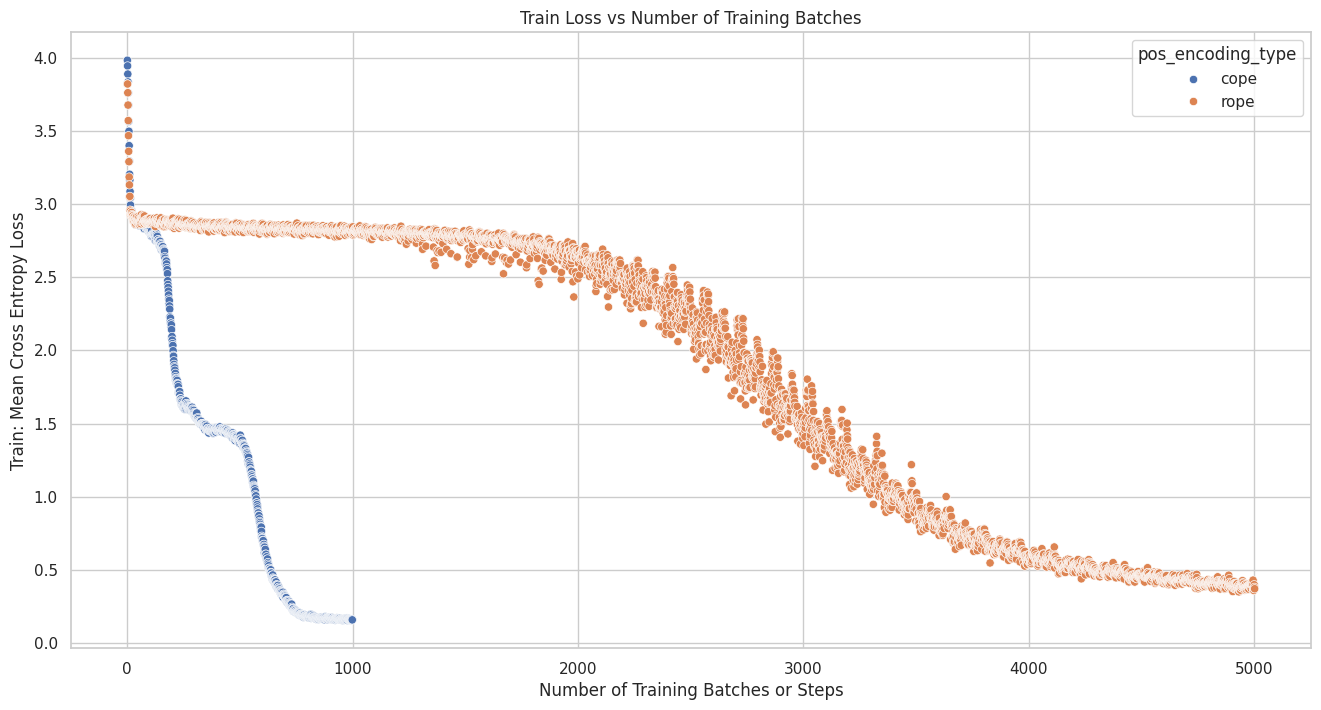

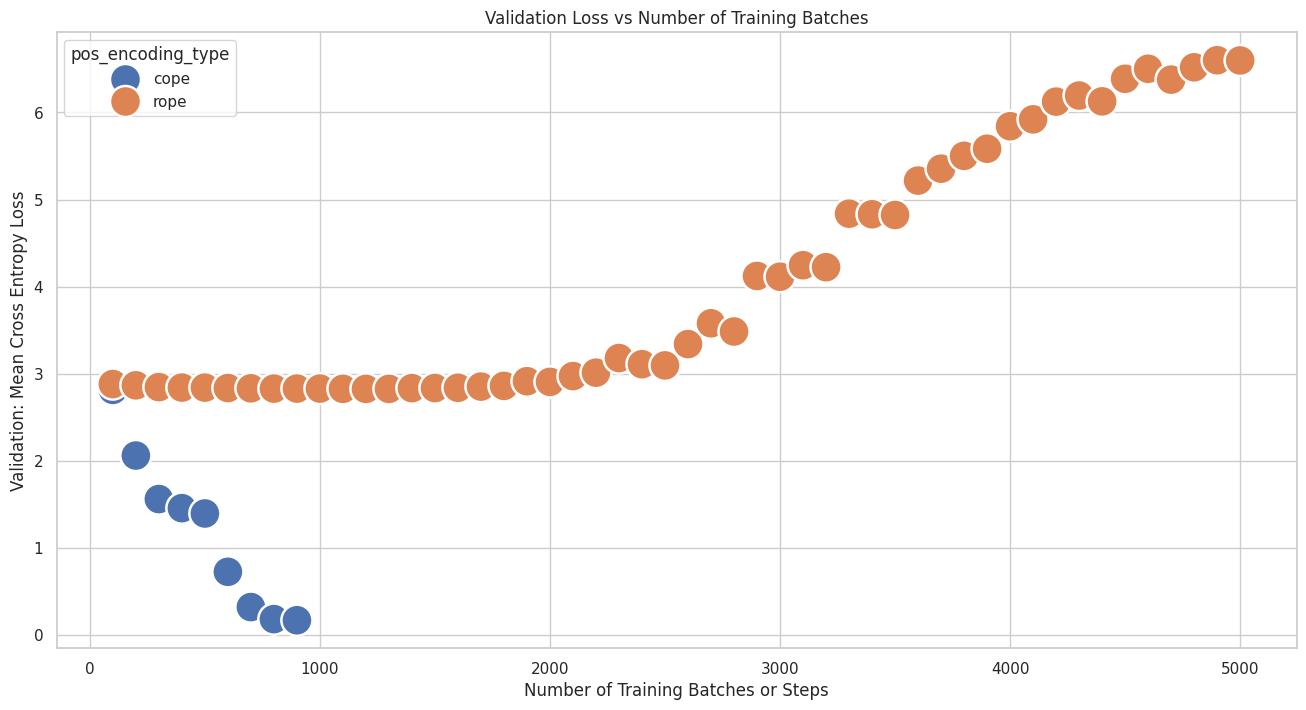

In [151]:
# Plot
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter1d

# Set theme
sns.set(rc={'figure.figsize':(16, 8)})
sns.set_style("whitegrid")

# Scatterplot of train_loss vs step and colored by pos_encoding_type
train_df = metric_df.query(f"metric == 'train_loss'")
sns.scatterplot(x=train_df["step"], y=train_df["value"], hue=train_df["pos_encoding_type"], sizes=10)
plt.ylabel("Train: Mean Cross Entropy Loss")
plt.xlabel("Number of Training Batches or Steps")
plt.title("Train Loss vs Number of Training Batches")
plt.show()

# Scatterplot of train_loss vs step and colored by pos_encoding_type
train_df = metric_df.query(f"metric == 'val_loss'")
sns.scatterplot(x=train_df["step"], y=train_df["value"], hue=train_df["pos_encoding_type"], s=100)
plt.ylabel("Validation: Mean Cross Entropy Loss")
plt.xlabel("Number of Training Batches or Steps")
plt.title("Validation Loss vs Number of Training Batches")

plt.show()